In [4]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, StratifiedKFold
from scipy import stats

from lightgbm import LGBMRegressor
import lightgbm as lgb

from catboost import CatBoostRegressor

from lifelines import KaplanMeierFitter, CoxPHFitter, NelsonAalenFitter
from scipy.stats import rankdata

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [1]:
import os
os.path.abspath("")

'/Users/hiro2/programming/python/jupyter-notebook/kaggle/competition'

In [11]:
class Project:
    TARGET = ['efs', 'efs_time']
    _path_list = ['./']

    def __init__(self):
        self.train = pd.read_csv(os.path.join(*self._path_list, 'train.csv'))
        self.test = pd.read_csv(os.path.join(*self._path_list, 'test.csv'))
        self.submission = pd.read_csv(os.path.join(*self._path_list, 'sample_submission.csv'))
        self.combined = pd.concat([self.train, self.test])

    def info(self):
        print("Train shape:", self.train.shape)
        print("Test shape:", self.test.shape)
        print("Combined shape:", self.combined.shape)

In [12]:
class Preprocess:
    def __init__(self, data):
        self._data = data
        self._num_cols = [col for col in data.select_dtypes(include=[np.number]).columns if col not in Project.TARGET]
        self._obj_cols = [col for col in data.select_dtypes(exclude=[np.number]).columns if col not in Project.TARGET]

    def exec(self):
        self.missing_value_imputation()
        self.factorize()

        df_train = self._data[self._data['efs'].notnull()].copy()
        df_test = self._data[self._data['efs'].isnull()].copy()
        df_test = df_test.drop(columns=Project.TARGET).reset_index(drop=True)

        return df_train, df_test, df_train.ID

    def missing_value_imputation(self):
        self._data[self._num_cols] = self._data[self._num_cols].fillna(-1)
        self._data[self._obj_cols] = self._data[self._obj_cols].fillna('Unknown')

        return True

    def factorize(self):
        for col in self._obj_cols:
            self._data[col], _ = self._data[col].factorize()
            self._data[col] -= self._data[col].min()
            self._data[col] = self._data[col].astype('int32')
            self._data[col] = self._data[col].astype('category')
        return True

#　FEATURE

In [13]:
class FE:
    def __init__(self, data):
        self.data = data
        self._cat_cols = list(data.select_dtypes(exclude=[np.number]).columns)
        self._cv = KFold(n_splits = 5, shuffle = True, random_state = 123)

    def create_with_valid(self, new_name, fe_method):
        oof_preds = np.zeros(len(self.data))

        for t_idx, v_idx in self._cv.split(self.data):
            tr_x = self.data.iloc[t_idx]
            va_x = self.data.iloc[v_idx]
            oof_preds[v_idx] = getattr(self, fe_method, 'No FE Method')(tr_x, va_x)
        self.data[new_name] = oof_preds

        return self.data

    def survival_time(self, tr_x, va_x):
        kmf = KaplanMeierFitter()
        kmf.fit(tr_x.efs_time, tr_x.efs)

        return kmf.survival_function_at_times(va_x.efs_time).values

    def partial_hazard(self, tr_x, va_x):
        tr = pd.get_dummies(tr_x, columns=self._cat_cols, drop_first=True).drop('ID', axis=1) 
        va = pd.get_dummies(va_x, columns=self._cat_cols, drop_first=True).drop('ID', axis=1) 

        tr = tr.loc[:, tr.nunique() > 1]
        va = va[tr.columns]

        cph = CoxPHFitter(penalizer=0.01)
        cph.fit(tr, duration_col='efs_time', event_col='efs')

        return cph.predict_partial_hazard(va)

    def cumulative_hazard(self, tr_x, va_x):
        naf = NelsonAalenFitter()
        naf.fit(durations=tr_x.efs_time, event_observed=tr_x.efs)

        return -naf.cumulative_hazard_at_times(va_x['efs_time']).values

    def create_for_cox(self, new_name):
        self.data[new_name] = self.data.efs_time.copy()
        self.data.loc[self.data.efs == 0, new_name] *= -1

        return self.data

In [14]:
from eefs_concordance_index import score

def c_index_score(data, oof):
    y_true = data[['ID','efs','efs_time','race_group']].copy()
    y_pred = data[['ID']].copy()
    y_pred['prediction'] = oof
    m = score(y_true.copy(), y_pred.copy(), 'ID')

    return m

In [15]:
class Train:
    def __init__(self, data, target):
        self.data = data
        self._cat_cols = list(data.select_dtypes(exclude=[np.number]).columns)
        self.x = data.drop(['ID', 'efs', 'efs_time', 'TARGET_1', 'TARGET_2', 'TARGET_3', 'TARGET_4'], axis=1)
        self.y = target
        self._cv = KFold(n_splits=5, shuffle=True, random_state=123)

    def exec(self, select_model, params):
        oof_pred = np.zeros(len(df_train))
        models = []

        for nfold, (tr_idx, va_dx) in enumerate(self._cv.split(self.x, self.y)):
            print("-"*20, f" Fold {nfold+1}", "-"*20)

            x_tr, y_tr, x_va, y_va = self.x.iloc[tr_idx], self.y.iloc[tr_idx], self.x.iloc[va_dx], self.y.iloc[va_dx]
            model, pred = getattr(self, select_model, 'No Model')(params, x_tr, y_tr, x_va, y_va)
            models.append(model)
            oof_pred[va_dx] = pred
            s = c_index_score(df_train.iloc[va_dx], oof_pred[va_dx])
            print('c-index-score: ', s)

        return models, oof_pred

    def cbt(self, params, x_tr, y_tr, x_va, y_va):
        model = CatBoostRegressor(**params)
        model.fit(x_tr, y_tr, eval_set=(x_va, y_va), cat_features=self._cat_cols, verbose=0)
        pred = model.predict(x_va)

        return model, pred

    def lgb(self, params, x_tr, y_tr, x_va, y_va):
        model = LGBMRegressor(**params)
        model.fit(x_tr, y_tr,
                  eval_set=[(x_va, y_va)],
                  eval_metric='rmse',
                  callbacks=[lgb.early_stopping(250, verbose=0), lgb.log_evaluation(0)])
        pred = model.predict(x_va)

        return model, pred

In [16]:
project = Project()
df_train, df_test, df_train_id = Preprocess(project.combined).exec()

In [17]:
df_train

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,0,0,0,0,-1.0,-1.0,0,0,6.0,0,0,0,0,0,6.0,0,-1.0,2.0,0,6.0,2.0,0,2.0,2.0,0,0,0,0,2016,0,0,0,0,2.0,0,-1.000,0,2.0,0,9.942,2.0,0,0,0,2.0,0,0.0,90.0,0,0,0,0,8.0,0,2.0,0,10.0,0.0,42.356
1,1,1,0,1,0,2.0,8.0,1,0,6.0,1,0,0,0,1,6.0,0,10.0,2.0,1,6.0,2.0,0,2.0,2.0,1,1,1,0,2008,0,1,1,1,2.0,0,72.290,0,2.0,0,43.705,2.0,1,0,1,2.0,1,3.0,90.0,0,1,1,0,8.0,0,2.0,1,10.0,1.0,4.672
2,2,0,0,0,0,2.0,8.0,0,0,6.0,0,0,0,0,2,6.0,0,10.0,2.0,1,6.0,2.0,0,2.0,2.0,0,0,0,0,2019,0,0,0,0,2.0,0,-1.000,0,2.0,0,33.997,2.0,2,0,2,2.0,0,0.0,90.0,0,1,1,0,8.0,0,2.0,0,10.0,0.0,19.793
3,3,2,0,1,0,2.0,8.0,0,0,6.0,0,0,0,0,3,6.0,0,10.0,2.0,1,6.0,2.0,0,2.0,2.0,0,1,1,0,2009,0,1,1,1,2.0,0,29.230,0,2.0,0,43.245,2.0,3,0,3,2.0,2,0.0,90.0,1,1,0,0,8.0,0,2.0,0,10.0,0.0,102.349
4,4,2,0,0,0,2.0,8.0,0,0,6.0,1,0,0,0,4,6.0,0,10.0,2.0,0,5.0,2.0,0,2.0,2.0,1,0,1,1,2018,0,0,0,0,2.0,0,56.810,0,2.0,0,29.740,2.0,4,0,0,2.0,3,1.0,90.0,0,1,1,1,8.0,0,2.0,0,10.0,0.0,16.223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,28795,7,3,4,0,2.0,8.0,0,0,6.0,1,0,0,2,3,6.0,2,10.0,2.0,1,6.0,2.0,0,2.0,2.0,1,1,1,0,2018,0,2,0,3,2.0,0,24.212,1,2.0,0,51.136,2.0,7,1,0,2.0,0,0.0,-1.0,2,4,3,0,8.0,3,2.0,0,10.0,0.0,18.633
28796,28796,2,0,2,1,1.0,4.0,0,0,5.0,1,0,0,0,1,3.0,1,6.0,2.0,4,4.0,1.0,0,2.0,2.0,1,2,2,1,2017,0,1,1,0,1.0,0,30.770,0,1.0,0,18.075,2.0,8,0,0,1.0,4,3.0,90.0,0,2,1,0,6.0,1,1.0,1,8.0,1.0,4.892
28797,28797,6,3,2,3,2.0,8.0,0,2,6.0,1,0,1,2,9,6.0,1,10.0,2.0,4,6.0,2.0,1,2.0,2.0,1,3,1,0,2018,0,0,1,4,2.0,0,22.627,0,2.0,1,51.005,2.0,3,1,0,2.0,4,5.0,90.0,2,2,0,0,8.0,3,2.0,0,10.0,0.0,23.157
28798,28798,0,0,2,0,1.0,4.0,0,0,3.0,1,0,1,2,9,3.0,0,5.0,1.0,1,3.0,1.0,0,1.0,1.0,1,0,3,0,2018,2,0,0,0,1.0,0,58.074,1,1.0,1,0.044,1.0,2,0,3,1.0,5,1.0,90.0,0,1,1,1,4.0,0,1.0,0,5.0,0.0,52.351


In [18]:
# df_train.filter(regex='^(hla_)', axis=1).columns
hla_weights = [
    0.6,
    0.8,
    1.0,
    
    1.6,
    1.8,
    2.0,
    
    0.8,
    0.8,
    0.8,
    
    1.0,
    1.0,
    1.0,

    0.8,
    0.8,
    1.0,
    1.0,
    1.2
]
hla_cols = [
    'hla_low_res_6',
    'hla_low_res_8',
    'hla_low_res_10',
    
    'hla_high_res_6',
    'hla_high_res_8',
    'hla_high_res_10',
    
    'hla_match_a_low',
    'hla_match_b_low',
    'hla_match_c_low',
    
    'hla_match_a_high',
    'hla_match_b_high',
    'hla_match_c_high',
    
    'hla_match_drb1_low',
    'hla_match_dqb1_low',
    'hla_match_drb1_high',
    'hla_match_dqb1_high',
    'hla_nmdp_6',
]
df_train['hla_ratio'] = np.dot(df_train[hla_cols], hla_weights)
df_test['hla_ratio'] = np.dot(df_test[hla_cols], hla_weights)

In [26]:
# non_importance_cols = [
#     'prior_tumor',
#     'hepatic_mild',
#     'tbi_status',
#     'melphalan_dose',
#     'pulm_moderate',
#     'tce_div_match',
#     'tce_imm_match',
#     'rheum_issue',
#     'gvhd_proph',
#     'prim_disease_hct',
#     'hepatic_severe',
#     'tce_match',
#     'psych_disturb',
#     'obesity',
#     'ethnicity',
#     'vent_hist',
#     'renal_issue',
#     'peptic_ulcer',
#     'cardiac',
#     'donor_related',
#     'arrhythmia',
#     'rituximab',
# ]
df_train = df_train.drop(hla_cols, axis=1)
# df_train = df_train.drop(non_importance_cols, axis=1)
df_test = df_test.drop(hla_cols, axis=1)
# df_test = df_test.drop(non_importance_cols, axis=1)

In [20]:
# age_cols = ['donor_age', 'age_at_hct']
# for col in age_cols:
#     df_train[col] = pd.cut(df_train[col], bins=np.arange(-1, 100, 5), right=False)
#     df_train[col], _ = df_train[col].factorize()
#     df_train[col] -= df_train[col].min()
#     df_train[col] = df_train[col].astype('int32')
#     df_train[col] = df_train[col].astype('category')

In [21]:
# race_groups = df_train.race_group.unique()
# for race in race_groups:
#     group = df_train[df_train.race_group == race]
#     fe = FE(group)
#     df_train.loc[fe.data.index, 'TARGET_1'] = fe.data['TARGET_1']
#     df_train.loc[fe.data.index, 'TARGET_2'] = fe.data['TARGET_2']
#     df_train.loc[fe.data.index, 'TARGET_3'] = fe.data['TARGET_3']
#     df_train.loc[fe.data.index, 'TARGET_4'] = fe.data['TARGET_4']

fe = FE(df_train)
fe.create_with_valid('TARGET_1','partial_hazard')
fe.create_with_valid('TARGET_2','cumulative_hazard')
fe.create_with_valid('TARGET_3','survival_time')
fe.create_for_cox('TARGET_4')
df_train = fe.data

In [28]:
RANDOM_SEED = 123

ctb_params_base = {
    'learning_rate': 0.03,
    'random_state': RANDOM_SEED,
    'task_type': 'CPU',
    'num_trees': 100,
    'subsample': 0.85,
    'reg_lambda': 8.0,
    'depth': 8,
}

ctb1_params = {
    'loss_function': 'RMSE'
}

cox1_params = {
    'loss_function': 'Cox',
    'grow_policy': 'Depthwise',
    'min_child_samples': 8,
}

cox2_params = {
    'loss_function': 'Cox',
    'grow_policy': 'Lossguide',
    'num_leaves': 32,
}

lgb_params = {
    'device': 'cpu',
    'objective': 'regression',
    'extra_trees': True,
    'metric': 'rmse',
    'verbose': -1,
    'seed': RANDOM_SEED,
    'min_child_samples': 32,
    'num_iterations': 20000,
    'learning_rate': 0.03,
    'max_bin': 128,
    'num_leaves': 64,
    'feature_fraction': 0.9,
    'bagging_freq': 1,
    'bagging_fraction': 0.9,
    'reg_lambda': 8.0,
    'max_depth': 7,
}
ctb1_params.update(ctb_params_base)
cox1_params.update(ctb_params_base)
cox2_params.update(ctb_params_base)

In [29]:
# ctb_target_1_models, ctb_target_1_pred = Train(df_train, df_train['TARGET_1']).exec('cbt', ctb1_params)
# ctb_target_2_models, ctb_target_2_pred = Train(df_train, df_train['TARGET_2']).exec('cbt', ctb1_params)
# ctb_target_3_models, ctb_target_3_pred = Train(df_train, df_train['TARGET_3']).exec('cbt', ctb1_params)
# ctb_target_4_1_models, ctb_target_4_1_pred = Train(df_train, df_train['TARGET_4']).exec('cbt', cox1_params)
# ctb_target_4_2_models, ctb_target_4_2_pred = Train(df_train, df_train['TARGET_4']).exec('cbt', cox2_params)

lgb_target_1_models, lgb_target_1_pred = Train(df_train, df_train['TARGET_1']).exec('lgb', lgb_params)
lgb_target_2_models, lgb_target_2_pred = Train(df_train, df_train['TARGET_2']).exec('lgb', lgb_params)
lgb_target_3_models, lgb_target_3_pred = Train(df_train, df_train['TARGET_3']).exec('lgb', lgb_params)

--------------------  Fold 1 --------------------
c-index-score:  0.646326796821142
--------------------  Fold 2 --------------------
c-index-score:  0.6379373777312393
--------------------  Fold 3 --------------------
c-index-score:  0.6452094033386623
--------------------  Fold 4 --------------------
c-index-score:  0.6515476517532351
--------------------  Fold 5 --------------------
c-index-score:  0.6373775882736613
--------------------  Fold 1 --------------------
c-index-score:  0.6551169842427497
--------------------  Fold 2 --------------------
c-index-score:  0.6531424910223061
--------------------  Fold 3 --------------------
c-index-score:  0.6584141631214984
--------------------  Fold 4 --------------------
c-index-score:  0.6547437791158988
--------------------  Fold 5 --------------------
c-index-score:  0.6473899404112101
--------------------  Fold 1 --------------------
c-index-score:  0.6513452122002852
--------------------  Fold 2 --------------------
c-index-score:  

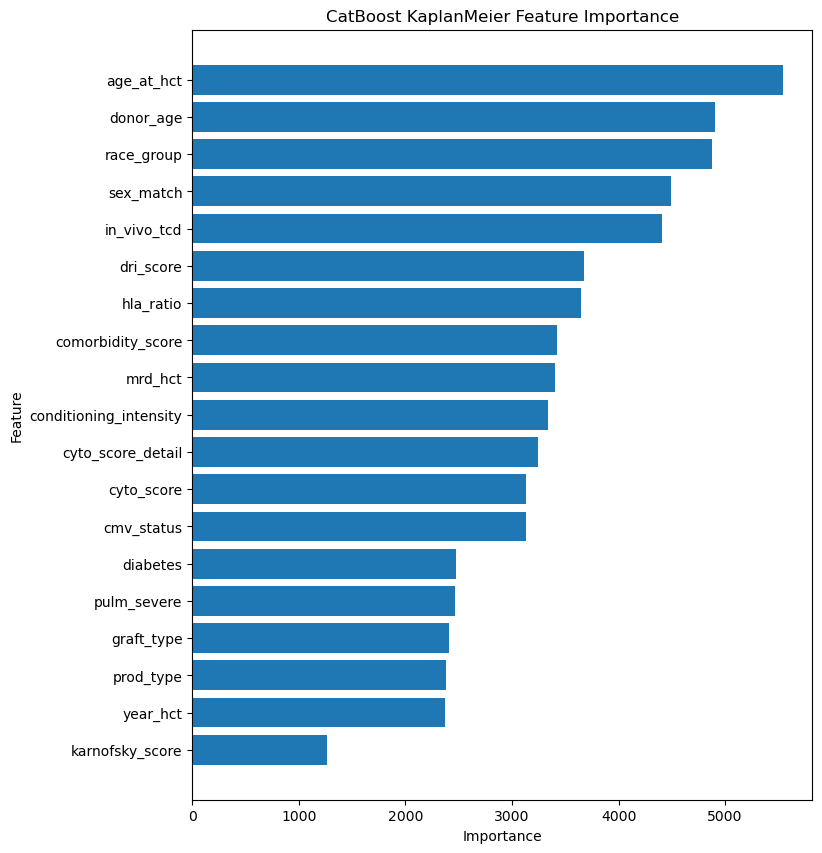

In [30]:
feature_importance = lgb_target_1_models[1].feature_importances_
features = [col for col in df_train.columns if col not in ['ID', 'efs', 'efs_time', 'TARGET_1', 'TARGET_2', 'TARGET_3', 'TARGET_4']]
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(8, 10))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("CatBoost KaplanMeier Feature Importance")
plt.gca().invert_yaxis()
plt.show()

In [57]:
weights = [1.0, 1.0, 8.0, 4.0, 8.0, 4.0, 6.0, 6.0]
oof_preds = [
    ctb_target_1_pred,
    lgb_target_1_pred,
    ctb_target_2_pred,
    lgb_target_2_pred,
    ctb_target_3_pred,
    lgb_target_3_pred,
    ctb_target_4_1_pred,
    ctb_target_4_2_pred,
]
ranked_preds = np.array([rankdata(p) for p in oof_preds])

ensemble_preds = np.dot(weights, ranked_preds)
m = c_index_score(df_train, ensemble_preds)
print(f"\nEnsemble Score =", m)


Ensemble Score = 0.6585113629602047


In [58]:
weights = [1.0, 1.0, 8.0, 4.0, 8.0, 4.0, 6.0, 6.0]
test_data = df_test.drop(['ID'], axis=1)

ctb_target_1_pred_test = np.mean([model.predict(test_data) for model in ctb_target_1_models], axis=0)
ctb_target_2_pred_test = np.mean([model.predict(test_data) for model in ctb_target_2_models], axis=0)
ctb_target_3_pred_test = np.mean([model.predict(test_data) for model in ctb_target_3_models], axis=0)
ctb_target_4_1_pred_test = np.mean([model.predict(test_data) for model in ctb_target_4_1_models], axis=0)
ctb_target_4_2_pred_test = np.mean([model.predict(test_data) for model in ctb_target_4_2_models], axis=0)

lgb_target_1_pred_test = np.mean([model.predict(test_data) for model in lgb_target_1_models], axis=0)
lgb_target_2_pred_test = np.mean([model.predict(test_data) for model in lgb_target_2_models], axis=0)
lgb_target_3_pred_test = np.mean([model.predict(test_data) for model in lgb_target_3_models], axis=0)

test_preds = [
    ctb_target_1_pred_test,
    lgb_target_1_pred_test,
    ctb_target_2_pred_test,
    lgb_target_2_pred_test,
    ctb_target_3_pred_test,
    lgb_target_3_pred_test,
    ctb_target_4_1_pred_test,
    ctb_target_4_2_pred_test,
]

ranked_preds = np.array([rankdata(p) for p in test_preds])
submit_preds = np.dot(weights, ranked_preds)

In [59]:
subm_data = project.submission.copy()
subm_data['prediction'] = submit_preds
subm_data.to_csv('submission.csv', index=False)
display(subm_data.head())

,ID,prediction
0,28800,61.0
1,28801,114.0
2,28802,53.0
